In [19]:
import cobra
import pandas as pd
import re
import numpy as np
import scipy.stats as st

In [20]:
import pubchempy as pcp

In [21]:
model = cobra.io.read_sbml_model('models/e_coli/momentiJO1366.xml')


In [22]:
# Read measurements
measurements = pd.read_csv('ecoli_measurements.csv')
#measurements.drop(columns = ["Note"], inplace = True)

In [23]:
# Read metabolite mapping
mapping_df = pd.read_csv('id_mapping.csv')

In [24]:
met_info_df = mapping_df[["Metabolite name", "Metabolite id"]]


In [25]:
met_info_df = pd.merge(met_info_df, measurements, on = "Metabolite name")

In [42]:
def get_polarity_from_pubchem(m):
    print(m.name)
    compounds = pcp.get_compounds(m.name, "name")
    if len(compounds) > 1:
        print([c.tpsa for c in compounds])
    elif not len(compounds): 
        print("No tpsa found for {0}".format(m.name))
        return np.nan
    c = compounds[0]
    print(c.synonyms[:2], c.tpsa)
    return c.tpsa
    

In [ ]:
mass = {}
charge = {}
n_phosphate = {}
polarity = {}
for i, row in met_info_df.iterrows():
    m_text = row["Metabolite id"]
    try:
        keys = m_text.split(",")
    except:
        print(m_text)
        continue
    formula_list = []
    mass_list = []
    charge_list = []
    np_list = []
    polar_list = []
    for key in keys:
        m_id = "{0}_c".format(key.strip())
        m = model.metabolites.get_by_id(m_id)
        mass_list.append(m.formula_weight)
        charge_list.append(m.charge)
        try:
            np_list.append(m.elements['P'])
        except KeyError:
            np_list.append(0)
        polar_list.append(get_polarity_from_pubchem(m))
            
        
    mass[i] = np.mean(mass_list)
    charge[i] = np.mean(charge_list)
    n_phosphate[i] = np.mean(np_list)
    polarity[i] = np.mean(polar_list)

In [44]:
met_info_df["Mass"] = pd.Series(mass)
met_info_df["Charge"] = pd.Series(charge)
met_info_df["Phosphate"] = pd.Series(n_phosphate)
met_info_df["Topological Polar Surface Area [Å]"] = pd.Series(polarity)

In [45]:
met_info_df.to_csv("met_info.csv")

In [47]:
met_info_df = met_info_df.loc[~met_info_df.isna().any(axis = 1), :]
met_info_df = met_info_df.loc[met_info_df.Value != 0, :]

In [48]:
met_info_df["log10(metabolite concentration)"] = np.log10(met_info_df.Value)

-0.2046507395799165 0.26119861655505655


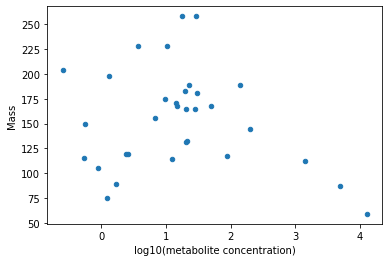

In [49]:
met_info_df.plot.scatter(x = "log10(metabolite concentration)", y = "Mass")
corrp = st.pearsonr(met_info_df["log10(metabolite concentration)"], met_info_df.Mass)
print(corrp[0], corrp[1])

-0.23295188568842964 0.1994625802825393


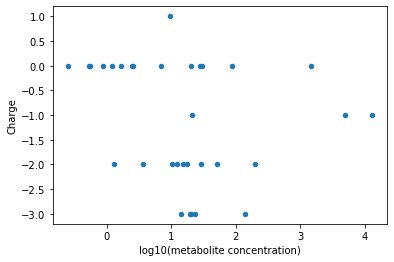

In [50]:
met_info_df.plot.scatter(x = "log10(metabolite concentration)", y = "Charge")
corrp = st.pearsonr(met_info_df["log10(metabolite concentration)"], met_info_df.Charge)
print(corrp[0], corrp[1])

-0.054931520346511935 0.7652437184094022


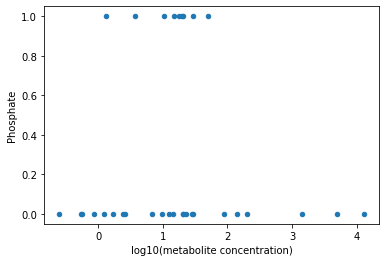

In [51]:
met_info_df.plot.scatter(x = "log10(metabolite concentration)", y = "Phosphate")
corrp = st.pearsonr(met_info_df["log10(metabolite concentration)"], met_info_df.Phosphate)
print(corrp[0], corrp[1])

-0.14272067538148706 0.4358439550028726


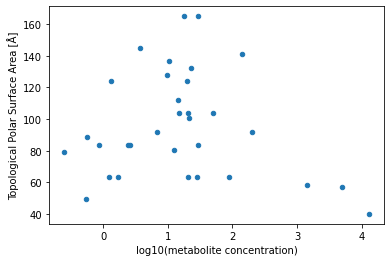

In [52]:
met_info_df.plot.scatter(x = "log10(metabolite concentration)", y = "Topological Polar Surface Area [Å]")
corrp = st.pearsonr(met_info_df["log10(metabolite concentration)"], met_info_df["Topological Polar Surface Area [Å]"])
print(corrp[0], corrp[1])